In [1]:
from tesistools import graphics_cafe
from tesistools import psychro
import psychrolib as ps #DOI  10.5281/zendi.2537945
ps.SetUnitSystem(ps.SI)
import pandas as pd
import matplotlib.pyplot as plt
from dateutil.parser import parse
import numpy as np

In [2]:
def convec(df):
    
    Q = (df.DivCafe_Qrate_conv + df.DivCafeOeste_Qrate_conv + df.MuroEvap_Qrate_conv + df.MuroEvapEste_Qrate_conv + 
         df.MuroSur_Qrate_conv + df.S31_Qrate_conv   +  df.Piso_Qrate_conv +  df.Techo_Qrate_conv +  
         df.VentEnt_Qrate_conv + df.VentOeste_Qrate_conv + df.VentS1_Qrate_conv + df.VentS2_Qrate_conv)
    return(Q)
    


In [3]:
def adiabatic_T(fecha, T_out, rh_zone, w_out, mass_Windows, T_zonedt, T_zone2dt, T_zone3dt, dens_out, Patm = 87214,
               volume = 10*8.65*3.5, Cp = 1005, Ct = 1, dt = 60):
    
    m_inf         = mass_Windows
    
    w_zone        = ps.GetHumRatioFromRelHum(T_zonedt, rh_zone, Patm)
    dens_zone     =  round((1/(287*(T_zonedt+273.15)*(1+1.607858*w_zone)/Patm)),6)
    Cz            = dens_zone*Cp*volume
    
    numerador   = m_inf * Cp * T_out  + (Cz/dt)* (T_zonedt) 
    denominador = (Cz/dt)  + m_inf*Cp 
    
    #cálculo de cargas convectivas por superficies
    Q_conve  = convec(fecha)
#     Q_conve, Q_zones  = convec_cEvap(fecha)
    
    Tz = (numerador + Q_conve) /(denominador)
    return Tz

In [4]:
def adiabatic_rh(Tz, T_out, rh_out, w_out, m_inf, T_zonedt, w_zonedt,
                 w_zone2dt, w_zone3dt, Patm, dt = 60, Vz = 8.65*10*3.5, Cw =1):
    
    dens_zone     =  round((1/(287*(T_zonedt+273.15)*(1+1.607858*w_zonedt)/Patm)),6)

    numerador  = m_inf * w_out  + (dens_zone*Vz*Cw/dt) * (w_zonedt) #1/2
    denominador = (dens_zone*Vz*Cw/dt) + m_inf
    
    w  = numerador/denominador 
    
    pg = ps.GetSatVapPres(Tz)
    rh = (w*Patm/((0.62198+w)*pg))*100

    return w, rh

In [5]:
def adiabatic_mix(data, Volume, ts = 60, CP = 1005, CT = 1, CW = 1):
    inicio   = str(data.index[0])
    final    = str(data.index[-1])
    freq     = "1min"
    fechas   = pd.date_range(inicio, final, freq=freq)
    
    temp     = [data.t_zone.iloc[0],data.t_zone.iloc[1],data.t_zone.iloc[2]]
    rh       = [data.rh_zone.iloc[0],data.rh_zone.iloc[1],data.rh_zone.iloc[2]]
    w        = [data.wi_zone.iloc[0], data.wi_zone.iloc[1], data.wi_zone.iloc[2]]
    
    
    
    for i in np.arange(3,len(fechas)):
        fecha = data.iloc[i]
        
        Tz    = adiabatic_T(fecha, fecha.t_out, rh[-1]/100, fecha.w_out, fecha.ventilation_mass/60, 
                           temp[-1], temp[-2], temp[-3], fecha.Dens_out, fecha.p_atm, 
                           volume = Volume, Cp = CP, Ct = CT, dt = ts)
        
        wz, RHz   = adiabatic_rh(Tz, fecha.t_out, fecha.rh_out, fecha.w_out, fecha.ventilation_mass/60, 
                                 temp[-1], w[-1], w[-2], w[-3], fecha.p_atm, dt = ts, Vz = Volume, Cw = CW)
        
        temp.append(Tz)
        rh.append(RHz)
        w.append(wz)
        
    data["t_zone_valid"]  = temp
    data["rh_zone_valid"] = rh  
    return(data)

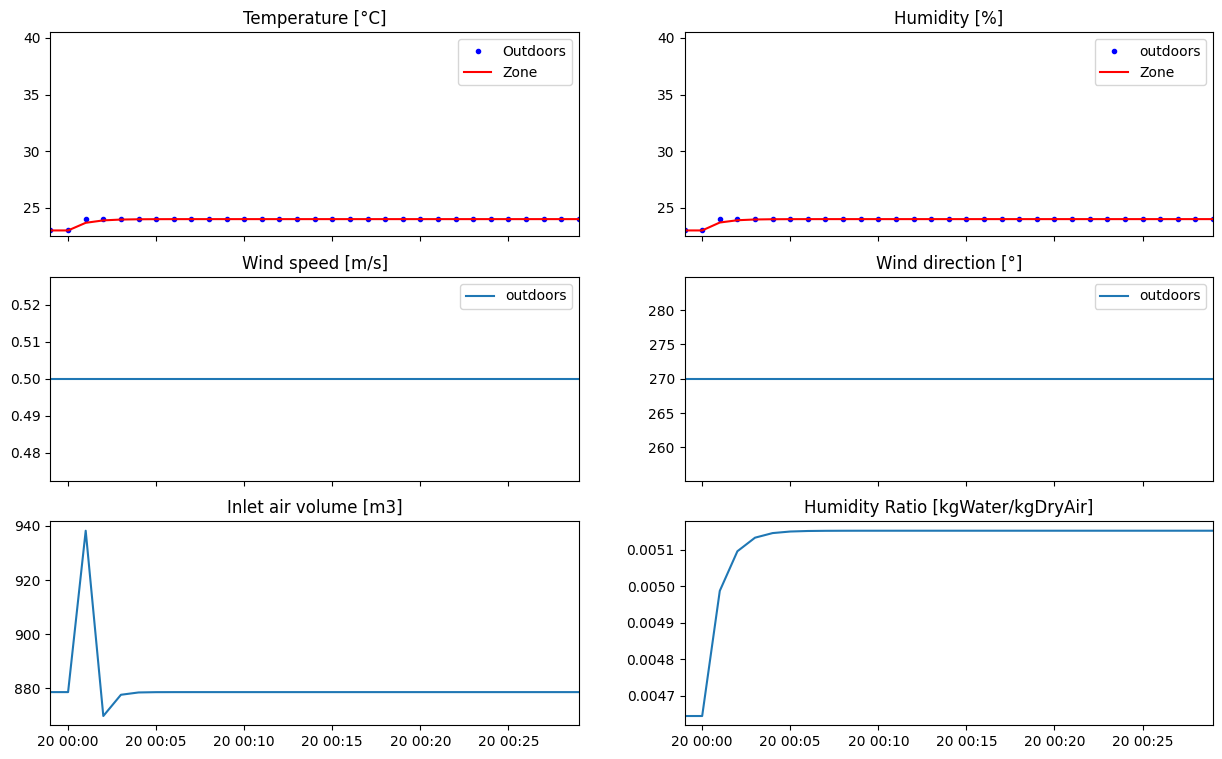

In [6]:
f      = "../idf/OneZone_OpenWind/Base23.csv"

inicio = "2018-01-01 00:01:00"
final  = "2018-02-01 00:00:00"
data   = graphics_cafe.import_csv(f, inicio, final)

# fecha1      =  "2018-01-15 23:59:00"
fecha1      = "2018-01-19 23:59:00"
timedelta   = "30min"
# ylim      = (None, None, None, None, None, None)
ylim      = ((22.5,40.5),(22.5,40.5),None, None,None, None)
graphics_cafe.graph_general(fecha1, timedelta, data, ylim)

In [7]:
volume  = (9.25*9.83*3.5) + (2.7*14*3.5)
Ts      = 60
exp     = adiabatic_mix(data, volume, Ts, CP =1013.4735858204)

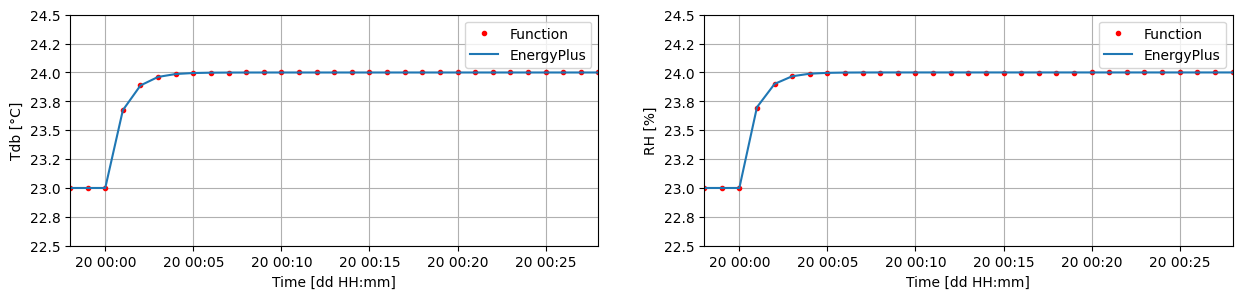

In [8]:
# fecha1    = "2018-01-19 23:59:00"
fecha1    = "2018-01-19 23:58:00"
timedelta = "30min"

ylim      = ((22.5,24.5),(22.5,24.5))
graphics_cafe.graph_EPyNum(exp, fecha1, timedelta, ylim)

In [9]:
t_errAbs  = abs(exp.t_zone  - exp.t_zone_valid)
rh_errAbs = abs(exp.rh_zone - exp.rh_zone_valid)

fecha1    = parse("2018-01-20 00:01:00")
timedelta = "180min"
fecha2    = fecha1 + pd.Timedelta(timedelta)

#Error absoluto
t_errAbs.loc[str(fecha1):str(fecha2)].mean(), rh_errAbs.loc[str(fecha1):str(fecha2)].mean()

(np.float64(0.0001480529240155091), np.float64(0.00022357204404420812))

In [10]:
#Desviación estándar
t_errAbs.loc[str(fecha1):str(fecha2)].std(), rh_errAbs.loc[str(fecha1):str(fecha2)].std()

(np.float64(0.00019296628289625458), np.float64(0.0003344943506538626))

In [11]:
#Error máximo
t_errAbs.loc[str(fecha1):str(fecha2)].max(), rh_errAbs.loc[str(fecha1):str(fecha2)].max()
# data.loc[str(t_errAbs.idxmax())] 

(np.float64(0.001365836768957962), np.float64(0.0026068241657242197))

In [12]:
exp[["t_zone", "t_zone_valid","rh_zone", "rh_zone_valid"]].loc["2018-01-20 00:01:00":"2018-01-20 00:08:00"]

,t_zone,t_zone_valid,rh_zone,rh_zone_valid
date,,,,
2018-01-20 00:01:00,23.673850,23.674953,23.699258,23.696651
2018-01-20 00:02:00,23.887823,23.889189,23.900876,23.898459
2018-01-20 00:03:00,23.961509,23.962589,23.967266,23.965545
2018-01-20 00:04:00,23.986656,23.987506,23.989359,23.988078
2018-01-20 00:05:00,23.995253,23.995955,23.996720,23.995688
2018-01-20 00:06:00,23.998208,23.998800,23.999152,23.998292
2018-01-20 00:07:00,23.999231,23.999752,23.999947,23.999193
2018-01-20 00:08:00,23.999590,24.000065,24.000198,23.999512
